# Risikomodellierung in der Schadenversicherung mit Python

Dieses Notebook dient als Begleitmaterial zur Masterthesis "Risikomodellierung in der Schadenverischerung mit Python". Zur Ausführung des Notebooks wird Python 3.10 oder höher benötigt. Die verwendeten Bibliotheken finden sich in der 'environment.yml' Datei. Am einfachsten gelingt ein Setup mittels [Mamba](https://mamba.readthedocs.io/en/latest/installation/mamba-installation.html). Die Installation einer geeigneten Entwicklungsumgebung inklusive Jupyter Kernel kann mit `mamba env create -f environment.yml` erfolgen. Es wurde inspieriert durch das scikit-learn Tutorial [Tweedie regression on insurance claims](https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html).

Es werden verschiedene Modelltypen vorgestellt. Wir betrachten hierbei ältere Modelle, wie das Marginalsummenverfahren nach Bailey, die aktuell überlicherweise verwendeten Generalisierten Linearen Modelle (GLMs), sowie die potentiell für die Risikomodellierung interessanten Gradient Boosting Machines (GBMs). Es wird gezeigt, wie diese Modelle zur Ermittlung der Netto-Risikoprämie verwendet werden können. Dabei werden direkte Modellierungsansätze, sowie kombinierte Ansätze auf Basis der Schadenhäufigkeit und -höhe vorgestellt. Die entwickelten Modelle werden anhand verschiedener Dimensionen bewertet:

- einer Vielzahl von Leistungsmetriken
- der Vorhersage des [Gesamtschadenaufwands](#totalclaimamount)
- der Fähigkeit, Risiken zu rangieren

Schließlich werden verschiedene Methoden zur Erklärung der Modelle vorgestellt.

## Daten

Die in diesem Notebook verwendeten Daten sind der "French Motor Third-Party Liability Claims" Datensatz von [OpenML](https://www.openml.org/). Dieser besteht aus zwei separaten Datensätzen, einem für die Schadenhäufigkeit: [freMTPL2freq](https://www.openml.org/d/41214) und einem für die Schadenhöhe: [freMTPL2sev](https://www.openml.org/d/41214). Für die folgenden Modellierungszwecke werden die beiden Datensätze auf Basis der Policy-ID zusammengeführt. Eine Police kann hierbei mehrere Schäden haben, diese müssen vor der Zusammenführung aggregiert werden.

In [1]:
from sklearn.datasets import fetch_openml

# freMTPL2freq dataset from https://www.openml.org/d/41214
df_freq = fetch_openml(data_id=41214, as_frame=True, parser="pandas").data
df_freq["IDpol"] = df_freq["IDpol"].astype(int)
df_freq.set_index("IDpol", inplace=True)

# freMTPL2sev dataset from https://www.openml.org/d/41215
df_sev = fetch_openml(data_id=41215, as_frame=True, parser="pandas").data

# sum ClaimAmount over identical IDs
df_sev = df_sev.groupby("IDpol").sum()

df = df_freq.join(df_sev, how="left")
df["ClaimAmount"] = df["ClaimAmount"].fillna(0)

# unquote string fields
for column_name in df.columns[df.dtypes.values == object]:
    df[column_name] = df[column_name].str.strip("'")

### Datenaufbereitung

Es gibt einige Aufbereitungsschritte, die für beide Datensätze durchgeführt werden müssen, andere Schritte müssen nur für bestimmte Modelltypen durchgeführt werden.

#### Allgemeine Schritte

Die Schadenanzahl wird später als Gewicht in der Modellierung der Schadenhähe verwendet. Da hierbei nur strikt positive Werte verwendet werden können, wird die Schadenanzahl für Schäden ohne Aufwand auf 0 gesetzt.

In [2]:
df.loc[(df["ClaimAmount"] == 0) & (df["ClaimNb"] >= 1), "ClaimNb"] = 0

Außergewöhnlich hohe Werte für die Anzahl der Schäden, die Jahreseinheiten und die Schadenhöhe werden abgeschnitten. Dies ist notwendig, um die Modelle zu stabilisieren und zu verhindern, dass sie von Ausreißern dominiert werden.

Beachte: In einem realen Szenario können wir den Schadenaufwand nicht einfach kappen und den gekappten Teil ignorieren. Wir müssten den überschüssigen Schadenaufwand auf die anderen Schäden verteilen. Es gibt verschiedene Möglichkeiten, dies zu tun. Dies wird hier aus Gründen der Einfachheit nicht durchgeführt.

In [3]:
df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)
df["ClaimAmount"] = df["ClaimAmount"].clip(upper=200000)

Bildung der verschiedenen Zielvariablen

In [4]:
import numpy as np

# Insurances companies are interested in modeling the Pure Premium, that is
# the expected total claim amount per unit of exposure for each policyholder
# in their portfolio:
df["PurePremium"] = df["ClaimAmount"] / df["Exposure"]

# This can be indirectly approximated by a 2-step modeling: the product of the
# Frequency times the average claim amount per claim:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]
# original approach
df["AvgClaimAmount"] = df["ClaimAmount"] / np.fmax(df["ClaimNb"], 1)

Train-Test Split

In [5]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, random_state=0)

Die Modelle für die Schadenhöhe werden nur auf Beobachtungen mit mindestens einem Schaden trainiert. Daher müssen wir nach diesen Beobachtungen filtern.

In [6]:
mask_train = df_train["ClaimAmount"] > 0
mask_test = df_test["ClaimAmount"] > 0

#### Marginalsummenverfahren spezifische Schritte

Die Implementierung des Marginalsummenverfahrens erfordert, dass alle Merkmale binär sind. Für die Merkmale ["VehAge", "DrivAge", "VehBrand", "VehPower", "VehGas", "Region", "Area"] können wir das Aufbereitung aus dem [scikit-learn Tutorial](https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html) verwenden. Für die Merkmale ["BonusMalus", "Density"] müssen wir die binären Merkmale selbst erstellen.

Beachte: In einem realen Szenario ist die Merkmalskonstruktion ein entscheidender Teil des Modellierungsprozesses. Es kann sehr mühsam und zeitaufwändig sein. In diesem Notebook gehen wir davon aus, dass die transformierten Merkmale gegeben sind und konzentrieren uns auf den Modellierungsteil.

In [7]:
import pandas as pd
from IPython import get_ipython

# special ipython function to get the html formatter
html_formatter = get_ipython().display_formatter.formatters["text/html"]

html_formatter.for_type(
    pd.DataFrame,
    lambda df: df.to_html(
        max_rows=pd.get_option("display.max_rows"), show_dimensions=True
    ),
)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    KBinsDiscretizer,
    OneHotEncoder,
    StandardScaler,
)

df_train["BonusMalusBin"] = pd.cut(
    df_train["BonusMalus"], bins=[0, 55, 57, 60, 68, 74, 86, 100, 120, 300]
)
df_train["DensityBin"] = pd.cut(
    df_train["Density"].apply(np.log),
    bins=[0, 2.5, 3, 3.8, 5, 6, 6.5, 7, 8, 11],
    include_lowest=True,
)
df_test["BonusMalusBin"] = pd.cut(
    df_test["BonusMalus"], bins=[0, 55, 57, 60, 68, 74, 86, 100, 120, 300]
)
df_test["DensityBin"] = pd.cut(
    df_test["Density"].apply(np.log),
    bins=[0, 2.5, 3, 3.8, 5, 6, 6.5, 7, 8, 11],
    include_lowest=True,
)

column_trans_mmt = ColumnTransformer(
    [
        (
            "binned_numeric",
            KBinsDiscretizer(n_bins=10, subsample=int(2e5), random_state=0),
            ["VehAge", "DrivAge"],
        ),
        (
            "onehot_categorical",
            OneHotEncoder(),
            [
                "VehBrand",
                "VehPower",
                "VehGas",
                "Region",
                "Area",
                "BonusMalusBin",
                "DensityBin",
            ],
        ),
    ],
    remainder="drop",
)
column_trans_mmt.fit(df_train)

X_train_mmt = column_trans_mmt.transform(
    df_train
).toarray()  # the implementation can't handle sparse matrix
X_test_mmt = column_trans_mmt.transform(
    df_test
).toarray()  # the implementation can't handle sparse matrix

To prepare for the Explainability part, we will extract the feature names of the transformed features.

In [8]:
# Get feature names
feature_names_mmt = []

# For binned_numeric
binned_numeric_transformer = column_trans_mmt.named_transformers_["binned_numeric"]
for feature, bin_edges in zip(
    ["VehAge", "DrivAge"], binned_numeric_transformer.bin_edges_
):
    for start, end in zip(bin_edges[:-1], bin_edges[1:]):
        feature_names_mmt.append(f"{feature}_bin_{start}_{end}")

# For onehot_categorical
onehot_features = column_trans_mmt.named_transformers_[
    "onehot_categorical"
].get_feature_names_out(
    [
        "VehBrand",
        "VehPower",
        "VehGas",
        "Region",
        "Area",
        "BonusMalusBin",
        "DensityBin",
    ]
)
feature_names_mmt.extend(onehot_features)

#### GLM specific steps

In difference to the MMT, the GLM can additionally handle continuous features. For the GLM we can use the preprocessing exactly as it is done in the [scikit-learn tutorial](https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html).

In [9]:
log_scale_transformer = make_pipeline(
    FunctionTransformer(func=np.log),
    StandardScaler(),
)

column_trans = ColumnTransformer(
    [
        (
            "binned_numeric",
            KBinsDiscretizer(n_bins=10, subsample=int(2e5), random_state=0),
            ["VehAge", "DrivAge"],
        ),
        (
            "onehot_categorical",
            OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
        ("passthrough_numeric", "passthrough", ["BonusMalus"]),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
    ],
    remainder="drop",
)
column_trans.fit(df)

X_train_glm = column_trans.transform(df_train)
X_test_glm = column_trans.transform(df_test)

To prepare for the Explainability part, we will extract the feature names of the transformed features.

In [10]:
# Get feature names
feature_names_glm = []

# For binned_numeric
binned_numeric_transformer = column_trans.named_transformers_["binned_numeric"]
for feature, bin_edges in zip(
    ["VehAge", "DrivAge"], binned_numeric_transformer.bin_edges_
):
    for start, end in zip(bin_edges[:-1], bin_edges[1:]):
        feature_names_glm.append(f"{feature}_bin_{start}_{end}")

# For onehot_categorical
onehot_features = column_trans.named_transformers_[
    "onehot_categorical"
].get_feature_names_out(["VehBrand", "VehPower", "VehGas", "Region", "Area"])
feature_names_glm.extend(onehot_features)

# For passthrough_numeric
feature_names_glm.append("BonusMalus")

# For log_scaled_numeric
feature_names_glm.append("Density_log")

#### GBM specific steps

As an implementation for Gradient Boosting we use the XGBoost library. There is a scikit-learn compatible API for XGBoost. Unfortunately, not all features used in the following process are as easy to use with the sklearn API as they are with the native API. Therefore, we will use the native XGBoost Python API.

Since XGBoost can handle categorical features, non-linear relationships and interactions out of the box, we will use the untransformed features to showcase these capabilities. Of course, we could also manually transform some or all of the features in a real world scenario.

To use the native API efficienlty, we need to convert the data into a [DMatrix](https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.core). Each DMatrix is specific to the objective.

In [11]:
import xgboost as xgb

df_train_xgb = df_train.copy()
df_test_xgb = df_test.copy()
categorical_features = ["VehBrand", "VehPower", "VehGas", "Region", "Area"]
numeric_features = ["BonusMalus", "VehAge", "DrivAge", "Density"]
feature_names_xgb = numeric_features + categorical_features

# convert categorical features to category dtype
df_train_xgb[categorical_features] = df_train_xgb[categorical_features].astype(
    "category"
)
df_test_xgb[categorical_features] = df_test_xgb[categorical_features].astype("category")

# init DMatrix for different objectives
# frequency
X_train_xgb_freq = xgb.DMatrix(
    df_train_xgb[categorical_features + numeric_features],
    label=df_train_xgb["Frequency"],
    weight=df_train_xgb["Exposure"],
    enable_categorical=True,
)
X_test_xgb_freq = xgb.DMatrix(
    df_test_xgb[categorical_features + numeric_features],
    label=df_test_xgb["Frequency"],
    weight=df_test_xgb["Exposure"],
    enable_categorical=True,
)
# severity
X_train_xgb_sev = xgb.DMatrix(
    df_train_xgb.loc[mask_train, categorical_features + numeric_features],
    label=df_train_xgb.loc[mask_train, "AvgClaimAmount"],
    weight=df_train_xgb.loc[mask_train, "ClaimNb"],
    enable_categorical=True,
)
X_test_xgb_sev = xgb.DMatrix(
    df_test_xgb.loc[mask_test, categorical_features + numeric_features],
    label=df_test_xgb.loc[mask_test, "AvgClaimAmount"],
    weight=df_test_xgb.loc[mask_test, "ClaimNb"],
    enable_categorical=True,
)
# pure premium
X_train_xgb_pure = xgb.DMatrix(
    df_train_xgb[categorical_features + numeric_features],
    label=df_train_xgb["PurePremium"],
    weight=df_train_xgb["Exposure"],
    enable_categorical=True,
)
X_test_xgb_pure = xgb.DMatrix(
    df_test_xgb[categorical_features + numeric_features],
    label=df_test_xgb["PurePremium"],
    weight=df_test_xgb["Exposure"],
    enable_categorical=True,
)

## Evaluation Methods

As mentioned above, we will evaluate the models based on three different dimensions. The first one is the performance of the models. The second one is the prediction of the total claim amount. The third one is the ability to rank risks.

### Performance metrics

The models will be evaluated based on the objective:

- All objectives:
    - [Mean Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error)
    - [Mean Squared Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error)
    - [D² explained](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.d2_tweedie_score.html#sklearn.metrics.d2_tweedie_score)
- Pure Premium:
    - [Mean Tweedie Deviance with various power parameters](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_tweedie_deviance.html#sklearn.metrics.mean_tweedie_deviance) 
- Frequency
    - [Mean Poisson Deviance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.)
- Severity:
    - [Mean Gamma Deviance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_gamma_deviance.html#sklearn.metrics.mean_gamma_deviance)

For ease of use, the evaluation will be done with a function based on the objective.

In [12]:
from functools import partial
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_tweedie_deviance,
    mean_poisson_deviance,
    mean_gamma_deviance,
    d2_tweedie_score,
)

tweedie_powers = [1.5, 1.7, 1.8, 1.9, 1.99, 1.999, 1.9999]


def score_estimator(
    estimator,
    X_train,
    X_test,
    df_train,
    df_test,
    target,
    weights,
    tweedie_powers=None,
):
    """Evaluate an estimator on train and test sets with different metrics"""

    metrics = [
        ("mean abs. error", mean_absolute_error),
        ("mean squared error", mean_squared_error),
    ]
    if tweedie_powers:
        metrics += [("D² explained", partial(d2_tweedie_score, power=1.9))]
        metrics += [
            (
                "mean Tweedie dev p={:.4f}".format(power),
                partial(mean_tweedie_deviance, power=power),
            )
            for power in tweedie_powers
        ]
    if target == "Frequency":
        metrics += [
            ("D² explained", partial(d2_tweedie_score, power=1)),
            ("mean Poisson dev", mean_poisson_deviance),
        ]
    if target == "AvgClaimAmount":
        metrics += [
            ("D² explained", partial(d2_tweedie_score, power=2)),
            ("mean Gamma dev", mean_gamma_deviance),
        ]

    res = []
    for subset_label, X, df in [
        ("train", X_train, df_train),
        ("test", X_test, df_test),
    ]:
        y, _weights = df[target], df[weights]
        for score_label, metric in metrics:
            if isinstance(estimator, tuple) and len(estimator) == 2:
                # Score the model consisting of the product of frequency and
                # severity models.
                est_freq, est_sev = estimator
                y_pred = est_freq.predict(X) * est_sev.predict(X)
            else:
                y_pred = estimator.predict(X)

            score = metric(y, y_pred, sample_weight=_weights)

            res.append({"subset": subset_label, "metric": score_label, "score": score})

    res = (
        pd.DataFrame(res)
        .set_index(["metric", "subset"])
        .score.unstack(-1)
        .round(4)
        .loc[:, ["train", "test"]]
    )
    return res

### Total Claim Amount

The total claim amount of the prediction should be as close as possible to the total claim amount of the actual data. If the total claim amount of the prediction is too high, the insurer will charge too much premium and might lose customers. If the total claim amount of the prediction is too low, the insurer will not charge enough premium and might go bankrupt.

We will compare $\sum_{i=1}^{n} ClaimAmount_{i}$ with $\sum_{i=1}^{n} PurePremiumPred_i \cdot Exposure_i$. Where in the case of the Frequency and Severity models, the $PurePremiumPred$ is calculated as $FreqPred_i \cdot SevPred_i$.

### Risk Ranking

The ability to rank risks is important for the insurer to be able to charge the right premium for each risk.

In [13]:
from sklearn.metrics import auc
from matplotlib import pyplot as plt

%matplotlib inline


def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    # order samples by increasing predicted risk:
    ranking = np.argsort(y_pred)
    ranked_exposure = exposure[ranking]
    ranked_pure_premium = y_true[ranking]
    cumulated_claim_amount = np.cumsum(ranked_pure_premium * ranked_exposure)
    cumulated_claim_amount /= cumulated_claim_amount[-1]
    cumulated_samples = np.linspace(0, 1, len(cumulated_claim_amount))
    return cumulated_samples, cumulated_claim_amount


def gini_score(cumulated_samples, cumulated_claim_amount):
    return 1 - 2 * auc(cumulated_samples, cumulated_claim_amount)


def plot_lorenz_curve(y_true, y_pred, exposure, label, ax):
    cumulated_samples, cumulated_claim_amount = lorenz_curve(y_true, y_pred, exposure)
    gini = gini_score(cumulated_samples, cumulated_claim_amount)
    label += " (Gini index: {:.3f})".format(gini)
    ax.plot(cumulated_samples, cumulated_claim_amount, linestyle="-", label=label)


def plot_oracle(y_true, exposure, ax):
    cumulated_samples, cumulated_claim_amount = lorenz_curve(y_true, y_true, exposure)
    gini = gini_score(cumulated_samples, cumulated_claim_amount)
    label = "Oracle (Gini index: {:.3f})".format(gini)
    ax.plot(
        cumulated_samples,
        cumulated_claim_amount,
        linestyle="-.",
        color="gray",
        label=label,
    )


def plot_random(ax):
    ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random baseline")


def plot_config(ax):
    ax.set(
        title="Lorenz Curves",
        xlabel="Fraction of policyholders\n(ordered by model from safest to riskiest)",
        ylabel="Fraction of total claim amount",
    )
    ax.legend(loc="upper left")


def plot_risk_ranking(y_true, exposure, model_predicitons):
    _, ax = plt.subplots(figsize=(8, 8))
    plot_random(ax)
    plot_oracle(y_true, exposure, ax)
    for label, y_pred in model_predicitons.items():
        plot_lorenz_curve(y_true, y_pred, exposure, label, ax)
    plot_config(ax)

## Modeling the Pure Premium directly

### Method of Marginal Totals

To my knowledge, there is no Python implementation of the Method of Marginal Totals. Therefore, we will implement it ourselves.

In [14]:
import warnings


class MarginalTotalsRegression:
    """Method of Marignal Totals used for regression.

    This estimator is based on the Method of Marginal Ttotals (MMT) by Bailey (1963).
    See https://www.casact.org/abstract/insurance-rates-minimum-bias for details.

    Parameters
    ----------
    max_iter : int, default=100
        Maximum number of iterations to perform.

    min_factor_change : float, default=0.001
        Minimum change in any factor to continue iterations.

    min_y_change : float, default=0.01
        Minimum change in y to continue iterations.

    baselines : list of int, default=None
        List of baseline features per group. The factors are 1 by design.

    verbose : int, default=0
        Controls verbosity of output.

    Attributes
    ----------
    factors_ : ndarray of shape (n_features,)
        The fitted factors.

    factors_change_ : ndarray of shape (n_features,)
        The change in factors between iterations.

    marginal_totals_ : ndarray of shape (n_features,)
        Marginal totals per feature.

    n_iter_ : int
        Number of iterations performed.

    total_ : float
        Total sum of y.

    y_change_ : float
        Change in y between iterations.

    y_mean_ : float
        Base value of the model.

    References
    ----------
    .. [1] Bailey, R. A. (1963). Insurance rates by minimum bias. Transactions of the Casualty Actuarial Society, 50, 4ff.


    Examples
    --------
    weights = np.array([300, 700, 600, 200])
    y = np.array([220, 330, 200, 300])
    X = np.array(
        [
            [1.0, 0.0, 0.0, 1.0],
            [1.0, 0.0, 1.0, 0.0],
            [0.0, 1.0, 0.0, 1.0],
            [0.0, 1.0, 1.0, 0.0],
        ]
    )

    mmt = MarginalTotalsRegression()
    mmt.fit(X, y, sample_weight=weights)
    """

    def __init__(
        self,
        max_iter=100,
        min_factor_change=0.001,
        min_y_change=0.01,
        baselines=None,
        verbose=0,
    ):
        self.max_iter = max_iter
        self.min_factor_change = min_factor_change
        self.min_y_change = min_y_change
        self.baselines = baselines if baselines is not None else []
        self.verbose = verbose

    def fit(self, X, y, sample_weight=None):
        """Fit the model to data matrix X and target(s) y.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Training data. The model expects all features to be binary.
            Sparse matrices are not supported.

        y : ndarray of shape (n_samples,)
            Target values.

        sample_weight : ndarray of shape (n_samples,), default=None
            Individual weights for each sample. If None, uniform weights are used.
        """
        if sample_weight is None:
            sample_weight = np.ones(X.shape[0])

        # init factors
        self.factors_ = np.ones(X.shape[1])
        self.factors_change_ = np.zeros(X.shape[1])

        # calculate marginal totals of original data
        self.marginal_totals_ = np.dot(X.T, y * sample_weight)

        # calculate total of original data
        self.total_ = np.sum(y * sample_weight)

        # init mean y
        X_factor = np.multiply(self.factors_, X)
        self.y_mean_ = self.total_ / np.sum(
            np.prod(X_factor, axis=1, where=X_factor > 0) * sample_weight
        )

        for i in range(1, self.max_iter + 1):
            self.n_iter_ = i

            # update factors
            for feature in range(X.shape[1]):
                # except baseline feature of group
                if feature not in self.baselines:
                    col_mask = [
                        True if i != feature else False for i in range(X.shape[1])
                    ]
                    row_mask = X[:, feature] > 0

                    X_factor = np.multiply(
                        self.factors_[col_mask], X[row_mask][:, col_mask]
                    )

                    calc_marginal_total = (
                        np.sum(
                            sample_weight[row_mask]
                            * np.prod(X_factor, axis=1, where=X_factor > 0)
                        )
                        * self.y_mean_
                    )

                    updated_factor = (
                        self.marginal_totals_[feature] / calc_marginal_total
                    )
                    self.factors_change_[feature] = np.absolute(
                        self.factors_[feature] - updated_factor
                    )
                    self.factors_[feature] = updated_factor

            # update y mean
            X_factor = np.multiply(self.factors_, X)
            updated_y_mean = self.total_ / np.sum(
                np.prod(X_factor, axis=1, where=X_factor > 0) * sample_weight
            )
            self.y_change_ = np.absolute(self.y_mean_ - updated_y_mean)
            self.y_mean_ = updated_y_mean

            if self.verbose > 1:
                print(f"Iteration {i} - y mean: {self.y_mean_}")

            if self.verbose > 2:
                print(
                    f"Iteration {i} - max absolute factor change:"
                    f" {np.max(np.absolute(self.factors_change_))}, y change:"
                    f" {self.y_change_}"
                )

            # Check early stopping criteria after each iteration
            if (
                np.max(self.factors_change_) < self.min_factor_change
                and self.y_change_ < self.min_y_change
            ):
                if self.verbose > 0:
                    print(f"Converged after {self.n_iter_} iterations.")
                break

            if i == self.max_iter:
                warnings.warn(
                    f"Did not converge after {self.max_iter} iterations.", UserWarning
                )

    def predict(self, X):
        """Predict target values for X.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Samples.

        Returns
        -------
        y : ndarray of shape (n_samples,)
            Predicted target values.
        """
        X_factor = np.multiply(self.factors_, X)
        return np.prod(X_factor, axis=1, where=X_factor != 0) * self.y_mean_

For simplicity we will use the first feature in each group as the reference category. In a real world scenario, we would choose the reference category with some heuristic.

Warning! The above implementation is very slow. It takes ~ 400 iterations and ~ 50 minutes to converge. You might want to skip this part by setting `run_mmt = False` in the below cell.

In [15]:
run_mmt = True

In [16]:
if run_mmt:
    mmt = MarginalTotalsRegression(
        max_iter=1000, baselines=[0, 10, 20, 31, 43, 45, 67, 73, 82]
    )
    mmt.fit(X_train_mmt, df_train["PurePremium"], sample_weight=df_train["Exposure"])

    scores_mmt = score_estimator(
        mmt,
        X_train_mmt,
        X_test_mmt,
        df_train,
        df_test,
        target="PurePremium",
        weights="Exposure",
        tweedie_powers=tweedie_powers,
    )

    scores_mmt

Luckily, the Method of Marignal Totals can be [derived from a Poisson GLM](https://www.cambridge.org/core/journals/astin-bulletin-journal-of-the-iaa/article/on-automobile-insurance-ratemaking/8986C8F3B46597B172F2FCAFCC170B2C). We can speed up the process by calculating a Poisson GLM and then transform the coefficients into the MMT factors.

Note: The GLM needs to be fitted with intercept and without regularization. Otherwise, the coefficients will not be the same as the MMT factors.

In [17]:
class AdditiveToMultiplicativeModel:
    """Convert an additive model to a multiplicative model.

    Parameters
    ----------
    model : object
        Additive model to convert. Must have a `coef_` and `intercept_` attribute.

    baselines : list of int, default=None
        List of baseline features, that are taken as reference categories. There should
        be one baseline feature per category. The factors are 1 by design.

    category_splits : list of int, default=None
        List of indices to split `coef_` into categories.

    Attributes
    ----------
    factors_ : ndarray of shape (n_features,)
        The fitted factors.

    y_mean_ : float
        Base value of the model.

    Examples
    --------
    from sklearn.linear_model import PoissonRegressor

    model = PoissonRegressor(alpha=0, fit_intercept=True)

    amm = AdditiveToMultiplicativeModel(model)
    amm.fit(X_train, y_train)

    amm.predict(X_test)
    """

    def __init__(self, model, baselines=None, category_splits=None):
        self.model = model
        self.baselines = baselines
        self.category_splits = category_splits if category_splits is not None else []

    def fit(self, X, y, sample_weight=None):
        """AdditiveToMultiplicativeModel fit.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Training data.

        y : ndarray of shape (n_samples,)
            Target values.

        sample_weight : ndarray of shape (n_samples,), default=None
            Individual weights for each sample. If None, uniform weights are used.
        """
        if sample_weight is None:
            sample_weight = np.ones(X.shape[0])

        self.model.fit(X, y, sample_weight=sample_weight)

        if self.baselines is None:
            self.factors_ = np.exp(self.model.coef_)
            self.y_mean_ = np.exp(self.model.intercept_)
        else:
            categories = np.split(self.model.coef_, self.category_splits)
            for category, baseline in zip(range(len(categories)), self.baselines):
                categories[category] = np.exp(
                    categories[category] - self.model.coef_[baseline]
                )
            self.factors_ = np.concatenate(categories)
            self.y_mean_ = np.exp(
                self.model.intercept_ + np.sum(self.model.coef_[self.baselines])
            )

    def predict(self, X):
        """Predict target values for X.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Samples.

        Returns
        -------

        y : ndarray of shape (n_samples,)
            Predicted target values.
        """
        X_factor = np.multiply(self.factors_, X)
        return np.prod(X_factor, axis=1, where=X_factor > 0) * self.y_mean_

In [18]:
from sklearn.linear_model import PoissonRegressor

glm_poisson_multiplicative = AdditiveToMultiplicativeModel(
    PoissonRegressor(alpha=0, max_iter=1000, fit_intercept=True),
    baselines=[0, 10, 20, 31, 43, 45, 67, 73, 82],
    category_splits=[10, 20, 31, 43, 45, 67, 73, 82],
)
glm_poisson_multiplicative.fit(
    X_train_mmt, df_train["PurePremium"], sample_weight=df_train["Exposure"]
)

score_glm_poisson_multiplicative = score_estimator(
    glm_poisson_multiplicative,
    X_train_mmt,
    X_test_mmt,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)

if run_mmt:
    scores = pd.concat(
        [
            score_glm_poisson_multiplicative,
            scores_mmt,
        ],
        axis=1,
        sort=True,
        keys=(
            "GLM Poisson Multiplicative",
            "MMT Compound",
        ),
    )

else:
    scores = pd.concat(
        [
            score_glm_poisson_multiplicative,
        ],
        axis=1,
        sort=True,
        keys=("GLM Poisson Multiplicative",),
    )

print("Evaluation of the PurePremium models:")
display(scores.T.loc[(slice(None), "train"), :])
display(scores.T.loc[(slice(None), "test"), :])

Evaluation of the PurePremium models:


,metric,D² explained,mean Tweedie dev p=1.5000,mean Tweedie dev p=1.7000,mean Tweedie dev p=1.8000,mean Tweedie dev p=1.9000,mean Tweedie dev p=1.9900,mean Tweedie dev p=1.9990,mean Tweedie dev p=1.9999,mean abs. error,mean squared error
,subset,,,,,,,,,,
GLM Poisson Multiplicative,train,0.0176,75.9181,36.6830,30.2968,33.7784,201.5103,1914.5149,19047.4474,273.0280,3.294525e+07
MMT Compound,train,0.0176,75.9187,36.6833,30.2970,33.7785,201.5104,1914.5150,19047.4474,273.0252,3.294524e+07


,metric,D² explained,mean Tweedie dev p=1.5000,mean Tweedie dev p=1.7000,mean Tweedie dev p=1.8000,mean Tweedie dev p=1.9000,mean Tweedie dev p=1.9900,mean Tweedie dev p=1.9990,mean Tweedie dev p=1.9999,mean abs. error,mean squared error
,subset,,,,,,,,,,
GLM Poisson Multiplicative,test,0.0138,76.3513,36.9076,30.4466,33.8750,201.5573,1914.3855,19045.5795,272.1904,3.211235e+07
MMT Compound,test,0.0138,76.3538,36.9087,30.4473,33.8754,201.5576,1914.3857,19045.5797,272.1873,3.211235e+07


Both models yield very similiar performance metrics.

In [19]:
if run_mmt:
    train = {
        "subset": "train",
        "observed": df_train["ClaimAmount"].values.sum(),
        "MMT Compound": np.sum(df_train["Exposure"] * mmt.predict(X_train_mmt)),
        "GLM Poisson Multiplicative": np.sum(
            df_train["Exposure"] * glm_poisson_multiplicative.predict(X_train_mmt)
        ),
    }

    test = {
        "subset": "test",
        "observed": df_test["ClaimAmount"].values.sum(),
        "MMT Compound": np.sum(df_test["Exposure"] * mmt.predict(X_test_mmt)),
        "GLM Poisson Multiplicative": np.sum(
            df_test["Exposure"] * glm_poisson_multiplicative.predict(X_test_mmt)
        ),
    }

else:
    train = {
        "subset": "train",
        "observed": df_train["ClaimAmount"].values.sum(),
        "GLM Poisson Multiplicative": np.sum(
            df_train["Exposure"] * glm_poisson_multiplicative.predict(X_train_mmt)
        ),
    }

    test = {
        "subset": "test",
        "observed": df_test["ClaimAmount"].values.sum(),
        "GLM Poisson Multiplicative": np.sum(
            df_test["Exposure"] * glm_poisson_multiplicative.predict(X_test_mmt)
        ),
    }

pd.DataFrame([train, test]).set_index("subset").T

subset,train,test
observed,3.917618e+07,1.299546e+07
MMT Compound,3.917618e+07,1.312350e+07
GLM Poisson Multiplicative,3.917618e+07,1.312356e+07


Both models yield very similiar predicted total claim amounts.

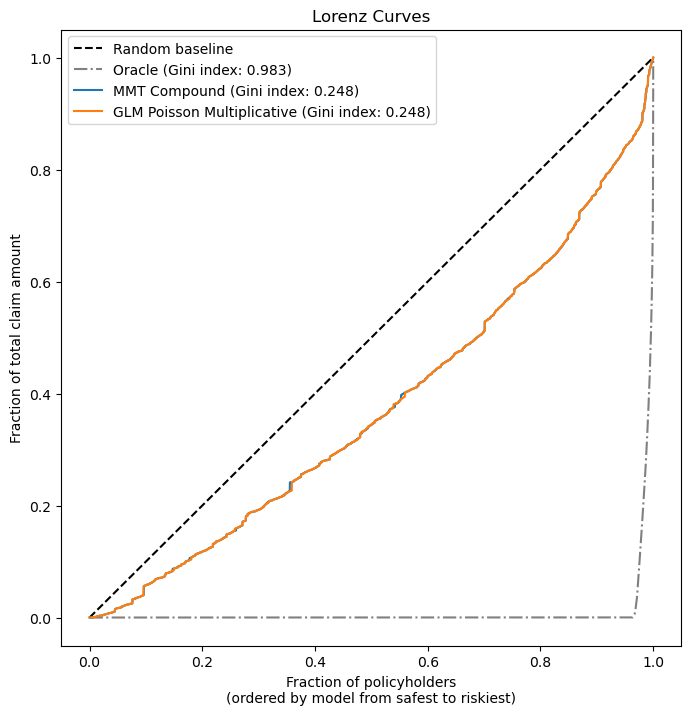

In [20]:
if run_mmt:
    plot_risk_ranking(
        df_test["PurePremium"],
        df_test["Exposure"],
        {
            "MMT Compound": mmt.predict(X_test_mmt),
            "GLM Poisson Multiplicative": glm_poisson_multiplicative.predict(
                X_test_mmt
            ),
        },
    )

else:
    plot_risk_ranking(
        df_test["PurePremium"],
        df_test["Exposure"],
        {
            "GLM Poisson Multiplicative": glm_poisson_multiplicative.predict(
                X_test_mmt
            ),
        },
    )

Both models yield very similiar risk rankings.

In [21]:
if run_mmt:
    print(f"MMT base value: {mmt.y_mean_}")
    print(f"GLM base value: {glm_poisson_multiplicative.y_mean_}")
    print(f"MMT factors: \n{mmt.factors_}")
    print(f"GLM factors: \n{glm_poisson_multiplicative.factors_}")

else:
    print(f"GLM base value: {glm_poisson_multiplicative.y_mean_}")
    print(f"GLM factors: \n{glm_poisson_multiplicative.factors_}")

MMT base value: 51.41807004211584
GLM base value: 51.419792189259965
MMT factors: 
[1.         1.17293338 1.22672794 1.04199219 1.05020153 1.16276324
 0.97144947 0.92413547 0.98385921 0.77450802 1.         0.61884899
 0.75065171 0.87330993 0.94227677 0.95362269 1.11770816 1.0403446
 0.99327089 1.22570093 1.         1.21036751 1.42739206 0.85135648
 1.13657208 0.83613174 1.13097297 1.20192806 1.1375874  1.06445281
 0.86151534 1.         0.88439281 1.11807215 1.1078048  0.99524317
 1.29093792 1.4330771  1.36799336 1.41238061 1.57934963 1.03537415
 0.83834402 1.         0.85855896 1.         2.58912259 1.44766405
 0.80456414 1.12512055 1.23572152 1.13268556 0.93204103 1.15750961
 0.68774532 0.82054051 0.90637322 1.16449631 1.0266706  1.12157314
 0.64568316 1.23428304 1.31975709 0.63057076 1.04878532 1.3017169
 2.20070983 1.         0.62024556 0.63097206 0.71978672 0.73232685
 0.54197505 1.         1.40762173 1.9383843  2.26228215 2.54746816
 2.68101553 4.27599568 6.60158372 7.83174798 1. 

Further, the base values and factors of models are very similiar. There are small differences in the last factors. This is due to the iterative nature of the MMT implementation. This could be reduced by decreasing the thresholds for the early stopping criteria even further. Nevertheless, we can replace the MMT with a Poisson GLM and save a lot of compute time.

### Generalized Linear Models

For modelling the PurePremium with Generalized Linear Models, a good idea is to use a Tweedie distribution with a power parameter between 1 and 2. The closer the power parameter is to 1, the more the distribution looks like a Poisson distribution. The closer the power parameter is to 2, the more the distribution looks like a Gamma distribution. These Tweedie distributions are continuous and allow for zero inflation. This is typical for insurance data.

Another practical approach is to use a Poisson distribution. Despite being a discrete distribution, it can be used for continuous data. The Poisson distribution is a special case of the Tweedie distribution with a power parameter of 1.

Note: For simplicity we will choose the power paramater a priori with a value of 1.9. Ideally, we would choose the power parameter based on the data by minimizing the log-likelihood over a grid of power parameters.

In [22]:
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import TweedieRegressor

np.random.seed(0)

glm_tweedie_pure = TweedieRegressor(power=1.9, alpha=0.1, solver="newton-cholesky")
glm_tweedie_pure.fit(
    X_train_glm, df_train["PurePremium"], sample_weight=df_train["Exposure"]
)

glm_poisson_pure = PoissonRegressor(
    alpha=0.1, fit_intercept=True, solver="newton-cholesky"
)
# glm_poisson_pure = PoissonRegressor(alpha=0, fit_intercept=True, max_iter=10000)
glm_poisson_pure.fit(
    X_train_glm.toarray(), df_train["PurePremium"], sample_weight=df_train["Exposure"]
)


tweedie_powers = [1.5, 1.7, 1.8, 1.9, 1.99, 1.999, 1.9999]

scores_glm_tweedie_pure = score_estimator(
    glm_tweedie_pure,
    X_train_glm,
    X_test_glm,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)

scores_glm_poisson_pure = score_estimator(
    glm_poisson_pure,
    X_train_glm,
    X_test_glm,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)


scores = pd.concat(
    [
        scores_glm_tweedie_pure,
        scores_glm_poisson_pure,
    ],
    axis=1,
    sort=True,
    keys=(
        "GLM Tweedie PurePremium",
        "GLM Poisson PurePremium",
    ),
)
print("Evaluation of the PurePremium models:")
display(scores.T.loc[(slice(None), "train"), :])
display(scores.T.loc[(slice(None), "test"), :])

Evaluation of the PurePremium models:


,metric,D² explained,mean Tweedie dev p=1.5000,mean Tweedie dev p=1.7000,mean Tweedie dev p=1.8000,mean Tweedie dev p=1.9000,mean Tweedie dev p=1.9900,mean Tweedie dev p=1.9990,mean Tweedie dev p=1.9999,mean abs. error,mean squared error
,subset,,,,,,,,,,
GLM Tweedie PurePremium,train,0.0164,76.4077,36.8288,30.3760,33.8212,201.5347,1914.5380,19047.4703,273.9865,3.295505e+07
GLM Poisson PurePremium,train,0.0168,76.1431,36.7659,30.3472,33.8091,201.5299,1914.5337,19047.4660,273.3377,3.294714e+07


,metric,D² explained,mean Tweedie dev p=1.5000,mean Tweedie dev p=1.7000,mean Tweedie dev p=1.8000,mean Tweedie dev p=1.9000,mean Tweedie dev p=1.9900,mean Tweedie dev p=1.9990,mean Tweedie dev p=1.9999,mean abs. error,mean squared error
,subset,,,,,,,,,,
GLM Tweedie PurePremium,test,0.0137,76.4088,36.9227,30.4539,33.8783,201.5587,1914.3868,19045.5807,273.1249,3.213056e+07
GLM Poisson PurePremium,test,0.0142,76.2371,36.8694,30.4237,33.8611,201.5482,1914.3768,19045.5708,272.5738,3.211700e+07


Both models yield very similiar performance metrics.

In [23]:
train = {
    "subset": "train",
    "observed": df_train["ClaimAmount"].values.sum(),
    "GLM Tweedie PurePremium": np.sum(
        df_train["Exposure"] * glm_tweedie_pure.predict(X_train_glm)
    ),
    "GLM Poisson PurePremium": np.sum(
        df_train["Exposure"] * glm_poisson_pure.predict(X_train_glm)
    ),
}

test = {
    "subset": "test",
    "observed": df_test["ClaimAmount"].values.sum(),
    "GLM Tweedie PurePremium": np.sum(
        df_test["Exposure"] * glm_tweedie_pure.predict(X_test_glm)
    ),
    "GLM Poisson PurePremium": np.sum(
        df_test["Exposure"] * glm_poisson_pure.predict(X_test_glm)
    ),
}

pd.DataFrame([train, test]).set_index("subset").T

subset,train,test
observed,3.917618e+07,1.299546e+07
GLM Tweedie PurePremium,3.951751e+07,1.325198e+07
GLM Poisson PurePremium,3.917618e+07,1.314235e+07


Both models are slightly overerstimating the total claim amount. The Tweedie model is a bit worse than the Poisson model.

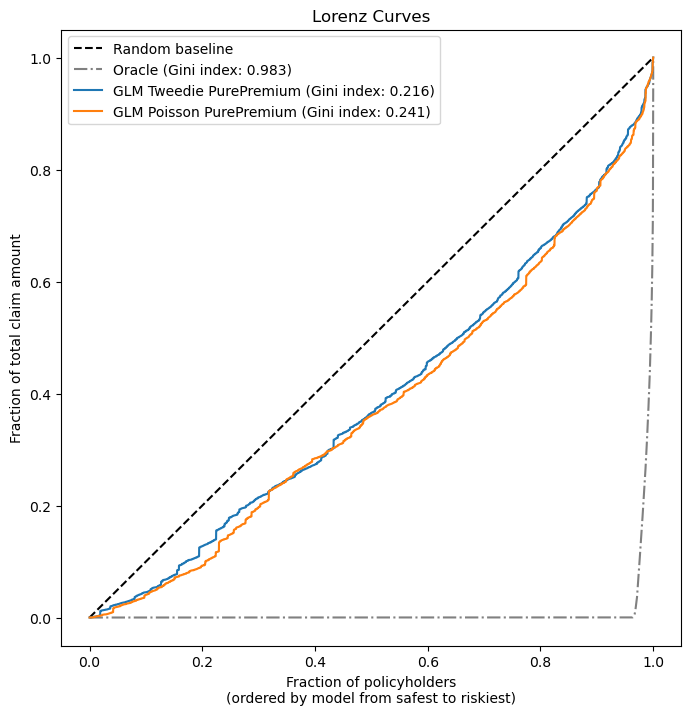

In [24]:
plot_risk_ranking(
    df_test["PurePremium"],
    df_test["Exposure"],
    {
        "GLM Tweedie PurePremium": glm_tweedie_pure.predict(X_test_glm),
        "GLM Poisson PurePremium": glm_poisson_pure.predict(X_test_glm),
    },
)

The risk ranking of the Poisson model is better than the risk ranking of the Tweedie model. This might be due to a poor a priori choice of the power parameter. Parameter tuning might improve the risk ranking of the Tweedie model.

#### Parameter Estimates

In actuarial science it is common to evaluate the parameter estimates of GLMs with statistical tests. Tools like SAS (proc genmod) and R (GLM) provide these tests out of the box. In Python there are several libraries to compute GLMs with different focus. The statsmodels library is the most similar to SAS and R. It provides statistical tests for the parameter estimates. However, scikit-learn doesn't provide statistical tests for the parameter estimates. The focus of this library is more on machine learning than on statistical inference.

If you need to calculate statistical tests for the parameter estimates, you can use the statsmodels library. However, keep in mind that the tests are limitied to unregularized GLMs with intercept. An alternative approach is to use bootstrapping to calculate confidence intervals for the parameter estimates. This approach is model agnostic and can be used for any GLM.

With respect to the following chapter (Gradient Boosting Machines), we will skip this, because GBMs are non-parametric.

### Gradient Boosting Machines

#### Hyperparameter Tuning

Gradient Boosting doesn't necessarily work well out of the box. It has several hyperparameters that need to be tuned. We will use the following sets of hyperparameters, that have been obtained by using a random search optimization. The number of boost rounds has been obtained by using early stopping.

In [25]:
best_params_xgb_tweedie = {
    "alpha": 0.028072221800410555,
    "colsample_bytree": 0.7468053850541801,
    "lambda": 1.4601095085621913,
    "learning_rate": 0.02732393009139623,
    "max_depth": 3,
    "min_child_weight": 177,
    "subsample": 0.6413275834237984,
}
boost_rounds_tweedie = 281

#### Under-/Overestimation of the total claim amount / pure premium

Gradient Boosting regression is a *non-parametric* method, i.e. it does not make any assumption on the shape of the regression function. It is therefore not guaranteed that the predicted total claim amount/pure premium will be equal to the true total claim amount /pure premium. This is especially the case for asymmetric loss functions, as we will see later. Therefore we use a wrapper to calibrate the predictions of the Gradient Boosting regressor.

In [26]:
class CalibratedRegressionBooster:
    """Wrapper to calibrate the output of an XGBoost regressor based
    on the training data.

    Parameters
    ----------
    booster : xgboost.Booster
        The trained XGBoost booster object.
    dtrain : xgboost.DMatrix
        The XGBoost training data.
    """

    def __init__(self, booster, dtrain):
        self.booster = booster
        self.dtrain = dtrain
        self.factor = self._get_factor()

    def _get_factor(self):
        """Compute the factor for calibration.

        The factor for calibration is the ratio of the sum of the target
        variable to the sum of the predictions of the XGBoost model on
        the training data.
        """
        y_sum = np.sum(self.dtrain.get_label() * self.dtrain.get_weight())
        predt = np.sum(self.booster.predict(self.dtrain) * self.dtrain.get_weight())
        return y_sum / predt

    def predict(self, X):
        """Predict using the calibrated XGBoost model.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The input samples.

        Returns
        -------
        y : ndarray of shape (n_samples,)
            The predicted values.
        """

        return self.booster.predict(X) * self.factor

Analogously to the GLM, we will use a Tweedie distribution with a power parameter of 1.9. Furthermore, we will take advantage of cuda accelerated training. This speeds up the training significantly and is a big deal in the context of GBMs, since they are very compute intensive. If you don't have a cuda device (typically Nvidia GPUs), you can either set the device to "cpu" or remove the device parameter.

Note: In contrast to GLMs, a Poisson model is not possible, because the implementation is specific to counting objectives and not able to handle continuous data.

In [27]:
xgb_tweedie_pure = xgb.train(
    params={
        **best_params_xgb_tweedie,
        "tree_method": "hist",
        "device": "cuda",
        "tweedie_variance_power": 1.9,
        "objective": "reg:tweedie",
    },
    dtrain=X_train_xgb_pure,
    num_boost_round=boost_rounds_tweedie,
    maximize=False,
    verbose_eval=False,
)

xgb_tweedie_pure_calibrated = CalibratedRegressionBooster(
    xgb_tweedie_pure,
    X_train_xgb_pure,
)


score_xgb_tweedie_pure = score_estimator(
    xgb_tweedie_pure,
    X_train_xgb_pure,
    X_test_xgb_pure,
    df_train_xgb,
    df_test_xgb,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)

score_xgb_tweedie_pure_calibrated = score_estimator(
    xgb_tweedie_pure_calibrated,
    X_train_xgb_pure,
    X_test_xgb_pure,
    df_train_xgb,
    df_test_xgb,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)

scores = pd.concat(
    [
        score_xgb_tweedie_pure,
        score_xgb_tweedie_pure_calibrated,
    ],
    axis=1,
    sort=True,
    keys=(
        "XGB Tweedie PurePremium",
        "XGB Tweedie PurePremium Calibrated",
    ),
)
print("Evaluation of the PurePremium models:")
display(scores.T.loc[(slice(None), "train"), :])
display(scores.T.loc[(slice(None), "test"), :])

Evaluation of the PurePremium models:


,metric,D² explained,mean Tweedie dev p=1.5000,mean Tweedie dev p=1.7000,mean Tweedie dev p=1.8000,mean Tweedie dev p=1.9000,mean Tweedie dev p=1.9900,mean Tweedie dev p=1.9990,mean Tweedie dev p=1.9999,mean abs. error,mean squared error
,subset,,,,,,,,,,
XGB Tweedie PurePremium,train,0.0261,73.9650,35.9380,29.8334,33.4888,201.3199,1914.3322,19047.2661,256.6825,3.293930e+07
XGB Tweedie PurePremium Calibrated,train,0.0255,73.9567,35.9629,29.8569,33.5083,201.3354,1914.3473,19047.2811,273.4426,3.293726e+07


,metric,D² explained,mean Tweedie dev p=1.5000,mean Tweedie dev p=1.7000,mean Tweedie dev p=1.8000,mean Tweedie dev p=1.9000,mean Tweedie dev p=1.9900,mean Tweedie dev p=1.9990,mean Tweedie dev p=1.9999,mean abs. error,mean squared error
,subset,,,,,,,,,,
XGB Tweedie PurePremium,test,0.0160,75.8405,36.7131,30.3259,33.7999,201.5081,1914.3382,19045.5330,255.6866,3.211108e+07
XGB Tweedie PurePremium Calibrated,test,0.0165,75.7024,36.6647,30.2967,33.7820,201.4965,1914.3271,19045.5219,272.4632,3.210983e+07


The performance metrics of both models are very similiar.

In [28]:
train = {
    "subset": "train",
    "observed": df_train["ClaimAmount"].values.sum(),
    "XGB Tweedie PurePremium": np.sum(
        df_train["Exposure"] * xgb_tweedie_pure.predict(X_train_xgb_pure)
    ),
    "XGB Tweedie PurePremium Calibrated": np.sum(
        df_train["Exposure"] * xgb_tweedie_pure_calibrated.predict(X_train_xgb_pure)
    ),
}

test = {
    "subset": "test",
    "observed": df_test["ClaimAmount"].values.sum(),
    "XGB Tweedie PurePremium": np.sum(
        df_test["Exposure"] * xgb_tweedie_pure.predict(X_test_xgb_pure)
    ),
    "XGB Tweedie PurePremium Calibrated": np.sum(
        df_test["Exposure"] * xgb_tweedie_pure_calibrated.predict(X_test_xgb_pure)
    ),
}

pd.DataFrame([train, test]).set_index("subset").T

subset,train,test
observed,3.917618e+07,1.299546e+07
XGB Tweedie PurePremium,3.405701e+07,1.138845e+07
XGB Tweedie PurePremium Calibrated,3.917617e+07,1.310027e+07


The raw XGB Tweedie model severly undererstimates the total claim amount. The calibrated XGB Tweedie model is very comparable to the multiplicate models and the Poisson GLM.

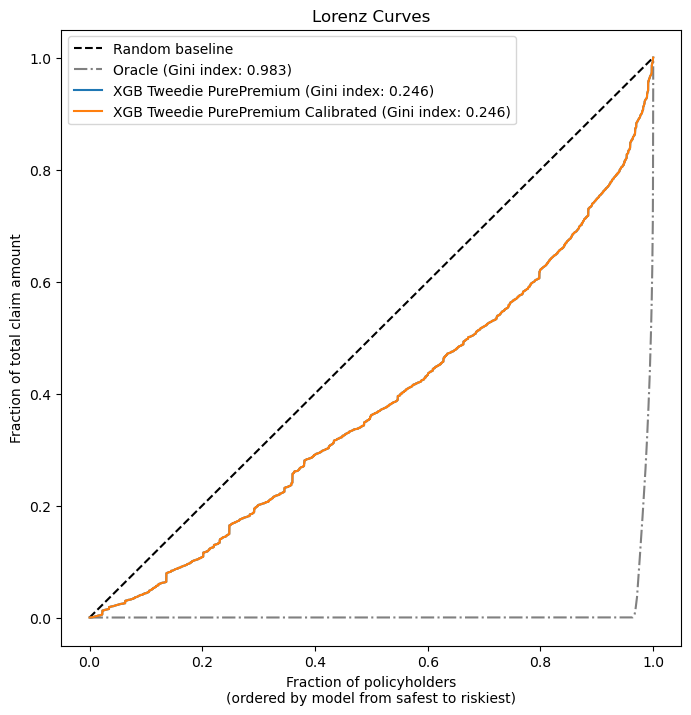

In [29]:
plot_risk_ranking(
    df_test["PurePremium"],
    df_test["Exposure"],
    {
        "XGB Tweedie PurePremium": xgb_tweedie_pure.predict(X_test_xgb_pure),
        "XGB Tweedie PurePremium Calibrated": xgb_tweedie_pure_calibrated.predict(
            X_test_xgb_pure
        ),
    },
)

The risk ranking of the XGB Tweedie model is similiar to the multiplicative models and the GLM Poisson model. As we can see, the calibration has no effect on the risk ranking and the two curves are overlapping.

## Modelling the Pure Premium via Frequency and Severity

### Frequency model -- Poisson distribution

The number of claims (``ClaimNb``) is a positive integer (0 included).
Thus, this target can be modelled by a Poisson distribution.
It is then assumed to be the number of discrete events occurring with a
constant rate in a given time interval (``Exposure``, in units of years).
Here we model the frequency ``y = ClaimNb / Exposure``, which is still a
(scaled) Poisson distribution, and use ``Exposure`` as `sample_weight`.

Let us keep in mind that despite the seemingly large number of data points in
this dataset, the number of evaluation points where the claim amount is
non-zero is quite small:


In [30]:
len(df_test)

169504

In [31]:
len(df_test[df_test["ClaimAmount"] > 0])

6237

In [32]:
best_params_xgb_poisson = {
    "alpha": 1.994140493625288,
    "colsample_bytree": 0.6340734410360876,
    "lambda": 0.008013593648196619,
    "learning_rate": 0.022071505695314412,
    "max_depth": 7,
    "min_child_weight": 145,
    "subsample": 0.9302303532384276,
}
boost_rounds_poisson = 945

As a consequence, we expect a significant variability in our
evaluation upon random resampling of the train test split.

The parameters of the GLM model are estimated by minimizing the Poisson deviance
on the training set via a Newton solver. Some of the features are collinear
(e.g. because we did not drop any categorical level in the `OneHotEncoder`),
we use a weak L2 penalization to avoid numerical issues.

For the XGBoost regressor, we use a Poisson objective function and the optimized
hyperparameters. For the frequency model, we will only lookt at the raw model.
Furthermore, we take advantage of cuda accelarated training. If you don't have a
cuda device available, you can set "device": "cpu" instead.

In [33]:
from sklearn.linear_model import PoissonRegressor

glm_poisson_freq = PoissonRegressor(alpha=1e-4, solver="newton-cholesky")
glm_poisson_freq.fit(
    X_train_glm, df_train["Frequency"], sample_weight=df_train["Exposure"]
)

xgb_poisson_freq = xgb.train(
    params={
        **best_params_xgb_poisson,
        "objective": "count:poisson",
        "tree_method": "hist",
        "device": "cuda",
    },
    dtrain=X_train_xgb_freq,
    num_boost_round=boost_rounds_poisson,
    maximize=False,
    verbose_eval=False,
)


scores_glm_poisson_freq = score_estimator(
    glm_poisson_freq,
    X_train_glm,
    X_test_glm,
    df_train,
    df_test,
    target="Frequency",
    weights="Exposure",
)

scores_xgb_poisson_freq = score_estimator(
    xgb_poisson_freq,
    X_train_xgb_freq,
    X_test_xgb_freq,
    df_train_xgb,
    df_test_xgb,
    target="Frequency",
    weights="Exposure",
)

scores = pd.concat(
    [scores_glm_poisson_freq, scores_xgb_poisson_freq],
    axis=1,
    sort=True,
    keys=("GLM Poisson Frequency", "XGB Poisson Frequency"),
)

print("Evaluation of Frequency Models:")
scores

Evaluation of Frequency Models:


GLM Poisson Frequency         XGB Poisson Frequency        
subset                             train    test                 train    test
metric                                                                        
D² explained                      0.0448  0.0427                0.0875  0.0644
mean Poisson dev                  0.4572  0.4561                0.4367  0.4458
mean abs. error                   0.1379  0.1378                0.1354  0.1361
mean squared error                0.2441  0.2246                0.2413  0.2224

The XGBoost frequency model has a slightly better performance than the GLM model on the mean Poisson deviance and explained deviance, the other metrics are almost the same.

#### Frequency Predicitions

Let's take a look at the predicitons of the two different models.

In [34]:
pred_glm_poisson_freq = glm_poisson_freq.predict(X_test_glm)
pred_xgb_poisson_freq = xgb_poisson_freq.predict(X_test_xgb_freq)

Mean Claim Frequencies

To compare the predicted mean claim frequency with the true observed mean claim frequency, we need to take the Exposure into account.

In [35]:
print(
    "mean frequency observed:"
    f" {np.average(df_test.Frequency, weights=df_test.Exposure):.4f}"
)
print(
    "mean frequency predicted by GLM:"
    f" {np.average(pred_glm_poisson_freq, weights=df_test.Exposure):.4f}"
)
print(
    "mean frequency predicted by XGB:"
    f" {np.average(pred_xgb_poisson_freq, weights=df_test.Exposure):.4f}"
)

mean frequency observed: 0.0736
mean frequency predicted by GLM: 0.0739
mean frequency predicted by XGB: 0.0738


Both models slightly overerstimate the mean claim frequency.

Min/Max Number of Claims

In [36]:
print(
    f"min/max claims observed: {(df_test.Frequency * df_test.Exposure).min():.4f},"
    f" {(df_test.Frequency * df_test.Exposure).max():.4f}"
)
print(
    "min/max claims predicted by GLM:"
    f" {(pred_glm_poisson_freq * df_test.Exposure).min():.4f},"
    f" {(pred_glm_poisson_freq * df_test.Exposure).max():.4f}"
)
print(
    "min/max claims predicted by XGB:"
    f" {(pred_xgb_poisson_freq * df_test.Exposure).min():.4f},"
    f" {(pred_xgb_poisson_freq * df_test.Exposure).max():.4f}"
)

min/max claims observed: 0.0000, 4.0000
min/max claims predicted by GLM: 0.0001, 3.7430
min/max claims predicted by XGB: 0.0000, 0.7717


XGBoost doesn't capure the tail of the distribution as well as the GLM model.

Plot the observed frequencies.

Text(0.5, 1.0, 'Observed Frequency')

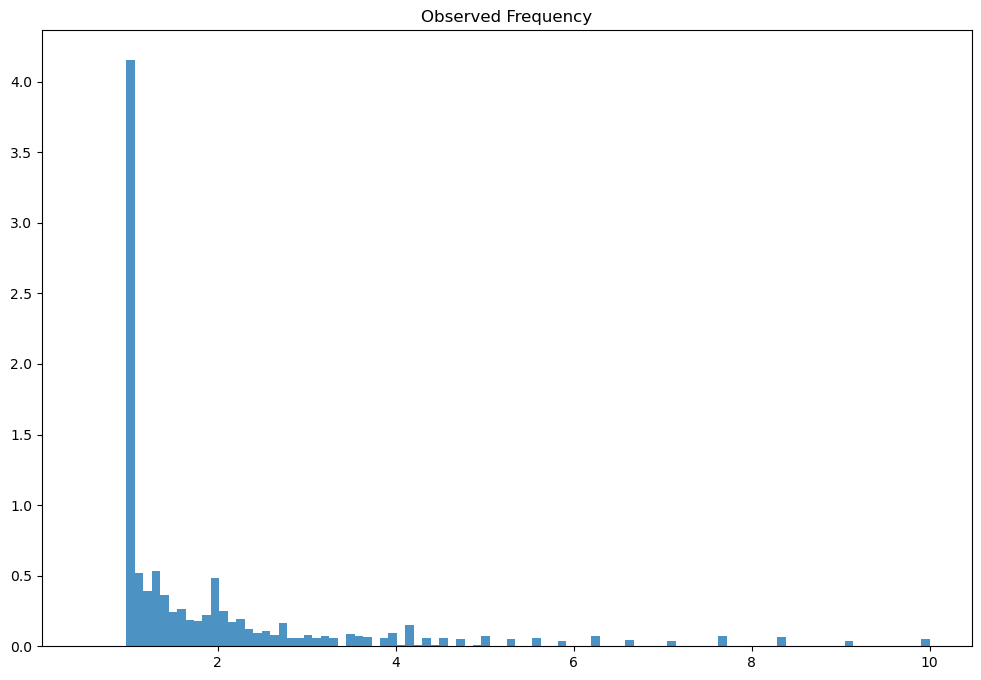

In [37]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(
    df_test["Frequency"],
    bins=100,
    label="Observed frequency",
    density=True,
    alpha=0.8,
    range=(0.5, 10),
)

ax.set_title("Observed Frequency")

The observed Frequencies have a high density at 0. To actually see anything, we ignore the 0 frequencies. We can observe that there is another high density at exactly 1.

Plot the predicted frequencies.

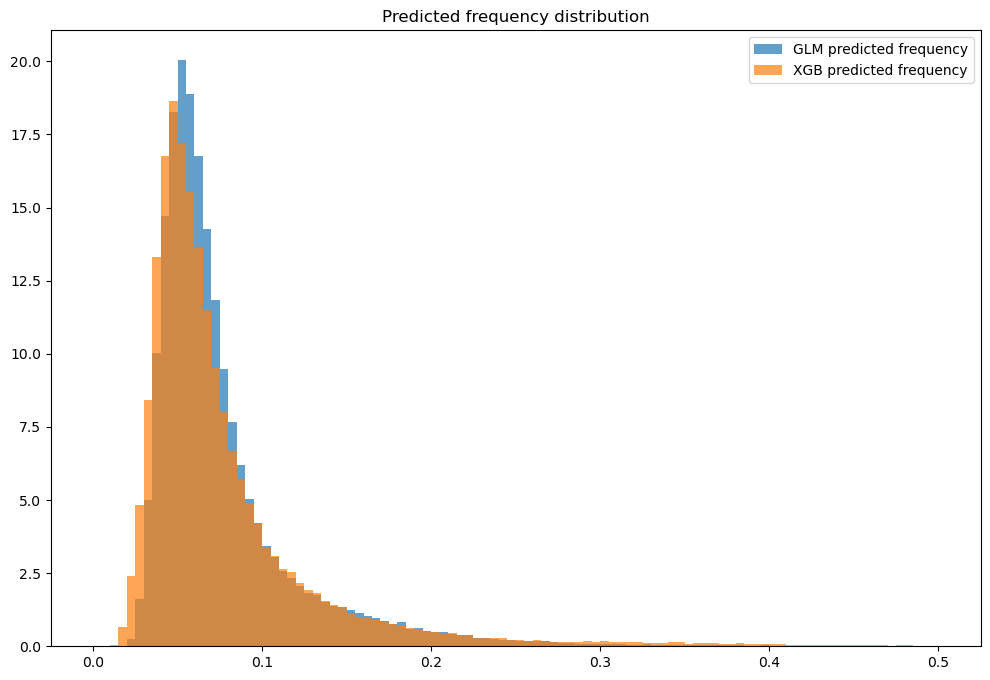

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(
    pred_glm_poisson_freq,
    bins=100,
    label="GLM predicted frequency",
    density=True,
    range=(0, 0.5),
    alpha=0.7,
)
ax.hist(
    pred_xgb_poisson_freq,
    bins=100,
    label="XGB predicted frequency",
    density=True,
    range=(0, 0.5),
    alpha=0.7,
)

ax.legend()
ax.set_title("Predicted frequency distribution");

Both distributions look very similiar. The areas of high density from the XGBoost predictions looks slighlty left shifted compared to the GLM predictions. The GLM has a longer tail (although it is capped here, we know that from the earlier analysis of the max ClaimNb).

### Severity Model -  Gamma distribution
The mean claim amount or severity (`AvgClaimAmount`) can be empirically
shown to follow approximately a Gamma distribution. We fit a GLM, an XGBoost and a calibrated XGBoost model for the severity with the same features as the frequency model.

Note:

- We filter out ``ClaimAmount == 0`` as the Gamma distribution has support
  on $(0, \infty)$, not $[0, \infty)$.
- We use ``ClaimNb`` as `sample_weight` to account for policies that contain
  more than one claim.



In [39]:
best_params_xgb_gamma = {
    "alpha": 0.6399765728900835,
    "colsample_bytree": 0.30104790017247346,
    "lambda": 0.0012592046178894732,
    "learning_rate": 0.07456133834046624,
    "max_depth": 3,
    "min_child_weight": 281,
    "subsample": 0.6532237673584566,
}
boost_rounds_gamma = 141

In [40]:
from sklearn.linear_model import GammaRegressor

glm_gamma_sev = GammaRegressor(alpha=10.0, solver="newton-cholesky")
glm_gamma_sev.fit(
    X_train_glm[mask_train.values],
    df_train.loc[mask_train, "AvgClaimAmount"],
    sample_weight=df_train.loc[mask_train, "ClaimNb"],
)

xgb_gamma_sev = xgb.train(
    params={
        **best_params_xgb_gamma,
        "objective": "reg:gamma",
        "tree_method": "hist",
        "device": "cuda",
    },
    dtrain=X_train_xgb_sev,
    num_boost_round=boost_rounds_gamma,
    maximize=False,
    verbose_eval=False,
)

xgb_gamma_sev_calibrated = CalibratedRegressionBooster(
    xgb_gamma_sev,
    X_train_xgb_sev,
)


scores_glm_gamma_sev = score_estimator(
    glm_gamma_sev,
    X_train_glm[mask_train.values],
    X_test_glm[mask_test.values],
    df_train[mask_train],
    df_test[mask_test],
    target="AvgClaimAmount",
    weights="ClaimNb",
)

scores_xgb_gamma_sev = score_estimator(
    xgb_gamma_sev,
    X_train_xgb_sev,
    X_test_xgb_sev,
    df_train_xgb[mask_train],
    df_test_xgb[mask_test],
    target="AvgClaimAmount",
    weights="ClaimNb",
)

scores_xgb_gamma_sev_calibrated = score_estimator(
    xgb_gamma_sev_calibrated,
    X_train_xgb_sev,
    X_test_xgb_sev,
    df_train_xgb[mask_train],
    df_test_xgb[mask_test],
    target="AvgClaimAmount",
    weights="ClaimNb",
)

scores = pd.concat(
    [scores_glm_gamma_sev, scores_xgb_gamma_sev, scores_xgb_gamma_sev_calibrated],
    axis=1,
    sort=True,
    keys=("GLM Gamma Severity", "XGB Gamma Severity", "XGB Gamma Severity Calibrated"),
)
print("Evaluation of Severity models:")
scores

Evaluation of Severity models:


GLM Gamma Severity               XGB Gamma Severity  \
subset                          train          test              train   
metric                                                                   
D² explained             3.900000e-03  4.400000e-03       5.940000e-02   
mean Gamma dev           1.435100e+00  1.394700e+00       1.355200e+00   
mean abs. error          1.756746e+03  1.744042e+03       1.670198e+03   
mean squared error       5.801770e+07  5.030677e+07       5.765112e+07   

                                 XGB Gamma Severity Calibrated                
subset                      test                         train          test  
metric                                                                        
D² explained        7.000000e-03                  5.910000e-02  9.200000e-03  
mean Gamma dev      1.391100e+00                  1.355700e+00  1.388000e+00  
mean abs. error     1.661536e+03                  1.747626e+03  1.741168e+03  
mean squared error  5.029665e+07                  5.761767e+07  5.028730e+07



Those values of the metrics are not necessarily easy to interpret. It can be
insightful to compare them with a model that does not use any input
features and always predicts a constant value, i.e. the average claim
amount, in the same setting:



In [41]:
from sklearn.dummy import DummyRegressor

dummy_sev = DummyRegressor(strategy="mean")
dummy_sev.fit(
    X_train_glm[mask_train.values],
    df_train.loc[mask_train, "AvgClaimAmount"],
    sample_weight=df_train.loc[mask_train, "ClaimNb"],
)

scores_dummy = score_estimator(
    dummy_sev,
    X_train_glm[mask_train.values],
    X_test_glm[mask_test.values],
    df_train[mask_train],
    df_test[mask_test],
    target="AvgClaimAmount",
    weights="ClaimNb",
)

scores = pd.concat(
    [
        scores_glm_gamma_sev,
        scores_xgb_gamma_sev,
        scores_xgb_gamma_sev_calibrated,
        scores_dummy,
    ],
    axis=1,
    sort=True,
    keys=(
        "GLM Gamma Severity",
        "XGB Gamma Severity",
        "XGB Gamma Severity Calibrated",
        "Dummy severity",
    ),
)
print("Evaluation of Severity models:")
scores

Evaluation of Severity models:


GLM Gamma Severity               XGB Gamma Severity  \
subset                          train          test              train   
metric                                                                   
D² explained             3.900000e-03  4.400000e-03       5.940000e-02   
mean Gamma dev           1.435100e+00  1.394700e+00       1.355200e+00   
mean abs. error          1.756746e+03  1.744042e+03       1.670198e+03   
mean squared error       5.801770e+07  5.030677e+07       5.765112e+07   

                                 XGB Gamma Severity Calibrated                \
subset                      test                         train          test   
metric                                                                         
D² explained        7.000000e-03                  5.910000e-02  9.200000e-03   
mean Gamma dev      1.391100e+00                  1.355700e+00  1.388000e+00   
mean abs. error     1.661536e+03                  1.747626e+03  1.741168e+03   
mean squared error  5.029665e+07                  5.761767e+07  5.028730e+07   

                   Dummy severity                
subset                      train          test  
metric                                           
D² explained         0.000000e+00 -0.000000e+00  
mean Gamma dev       1.440800e+00  1.400900e+00  
mean abs. error      1.756687e+03  1.744497e+03  
mean squared error   5.803882e+07  5.033764e+07

We conclude that the claim amount is very challenging to predict. All models are able to leverage at least some information from the input features to improve upon the mean baseline in terms of D². The differences on the other metrics are very small. The most noteworthy difference is the mean absolute error, where the uncalibrated XGB model is better than the GLM and the calibrated XGB model. Nevertheless, the calibration is necessary, as we will see in the next evaluations.

#### Severity Predictions

In [42]:
pred_glm_gamma_sev = glm_gamma_sev.predict(X_test_glm[mask_test])
pred_xgb_gamma_sev = xgb_gamma_sev.predict(X_test_xgb_sev)
pred_xgb_gamma_sev_calibrated = xgb_gamma_sev_calibrated.predict(X_test_xgb_sev)

Mean Severity

In [43]:
print(
    "Mean AvgClaim Amount per policy:              %.2f "
    % df_test["AvgClaimAmount"].mean()
)
print(
    "Mean AvgClaim Amount | NbClaim > 0:           %.2f"
    % df_test["AvgClaimAmount"][df_test["AvgClaimAmount"] > 0].mean()
)
print(
    "Predicted Mean AvgClaim Amount (GLM) | NbClaim > 0: %.2f"
    % pred_glm_gamma_sev.mean()
)
print(
    "Predicted Mean AvgClaim Amount (XGB) | NbClaim > 0: %.2f"
    % pred_xgb_gamma_sev.mean()
)
print(
    "Predicted Mean AvgClaim Amount (XGB calibrated) | NbClaim > 0: %.2f"
    % pred_xgb_gamma_sev_calibrated.mean()
)
print(
    "Predicted Mean AvgClaim Amount (dummy) | NbClaim > 0: %.2f"
    % dummy_sev.predict(X_test_glm).mean()
)

Mean AvgClaim Amount per policy:              70.94 
Mean AvgClaim Amount | NbClaim > 0:           1927.98
Predicted Mean AvgClaim Amount (GLM) | NbClaim > 0: 1975.26
Predicted Mean AvgClaim Amount (XGB) | NbClaim > 0: 1863.25
Predicted Mean AvgClaim Amount (XGB calibrated) | NbClaim > 0: 1977.72
Predicted Mean AvgClaim Amount (dummy) | NbClaim > 0: 1978.59


The uncalibrated XGBoost model severly underestimates the AvgClaim Amount and as a result the total ClaimAmount. This would lead to a loss for the insurance company. The calibrated XGBoost model is much better in this regard.

In [44]:
print("Total ClaimAmount:           %.2f" % df_test["ClaimAmount"].sum())
print(
    "Predicted total ClaimAmount (GLM): %.2f"
    % (pred_glm_gamma_sev * df_test.loc[mask_test, "ClaimNb"]).sum()
)
print(
    "Predicted total ClaimAmount (XGB): %.2f"
    % (pred_xgb_gamma_sev * df_test.loc[mask_test, "ClaimNb"]).sum()
)
print(
    "Predicted total ClaimAmount (XGB calibrated) | NbClaim > 0: %.2f"
    % (pred_xgb_gamma_sev_calibrated * df_test.loc[mask_test, "ClaimNb"]).sum()
)
print(
    "Predicted total ClaimAmount (dummy) | NbClaim > 0: %.2f"
    % (
        dummy_sev.predict(X_test_glm[mask_test]) * df_test.loc[mask_test, "ClaimNb"]
    ).sum()
)

Total ClaimAmount:           12995459.05
Predicted total ClaimAmount (GLM): 13065517.22
Predicted total ClaimAmount (XGB): 12319012.61
Predicted total ClaimAmount (XGB calibrated) | NbClaim > 0: 13075833.89
Predicted total ClaimAmount (dummy) | NbClaim > 0: 13070597.58


Note: Of course, we don't know the real ClaimNb in a real world scenario. We would need to to use the frequency model here.

Min/Max Claim Severity

In [45]:
print(
    f"min/max severity observed: {df_test.loc[mask_test, 'AvgClaimAmount'].min():.4f},"
    f" {df_test.loc[mask_test, 'AvgClaimAmount'].max():.4f}"
)
print(
    f"min/max severity predicted by GLM: {pred_glm_gamma_sev.min():.4f},"
    f" {pred_glm_gamma_sev.max():.4f}"
)
print(
    f"min/max severity predicted by XGB: {pred_xgb_gamma_sev.min():.4f},"
    f" {pred_xgb_gamma_sev.max():.4f}"
)
print(
    "min/max severity predicted by XGB calibrated:"
    f" {pred_xgb_gamma_sev_calibrated.min():.4f},"
    f" {pred_xgb_gamma_sev_calibrated.max():.4f}"
)

min/max severity observed: 1.4900, 200000.0000
min/max severity predicted by GLM: 1854.6965, 3155.0947
min/max severity predicted by XGB: 1098.5482, 3422.7051
min/max severity predicted by XGB calibrated: 1166.0377, 3632.9797


None of the models seems to catch the tail of the observed AvgClaimAmount distribution. Furthermore, both XGBoost models seem to span over a wider range of AvgClaimAmounts than the GLM model.

Plot the predicted severities.

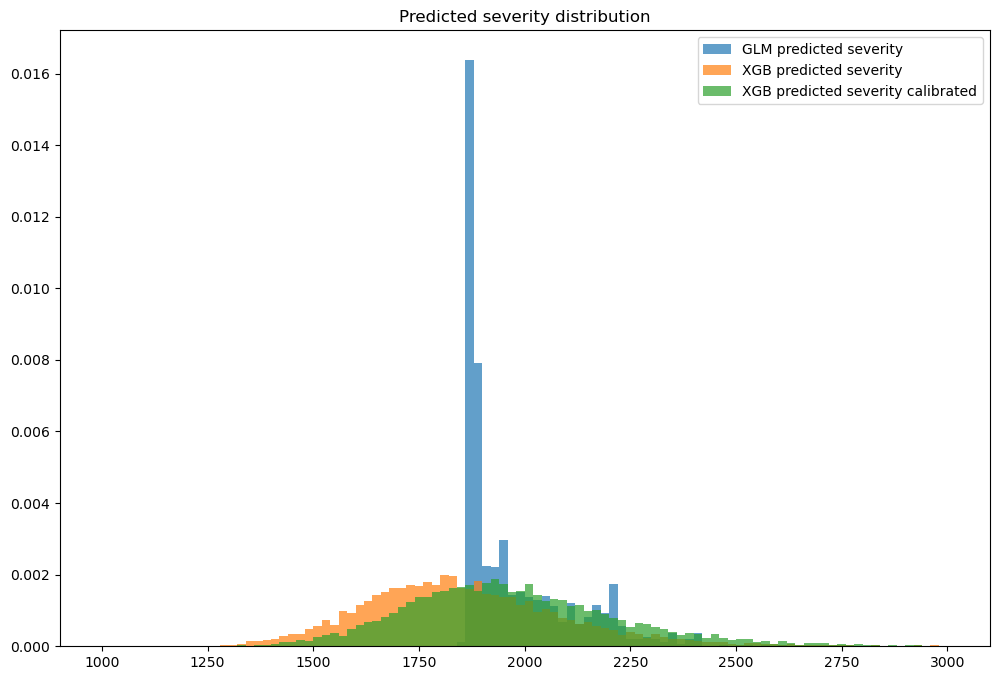

In [46]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(
    pred_glm_gamma_sev,
    bins=100,
    label="GLM predicted severity",
    density=True,
    alpha=0.7,
    range=(1000, 3000),
)
ax.hist(
    pred_xgb_gamma_sev,
    bins=100,
    label="XGB predicted severity",
    density=True,
    alpha=0.7,
    range=(1000, 3000),
)
ax.hist(
    pred_xgb_gamma_sev_calibrated,
    bins=100,
    label="XGB predicted severity calibrated",
    density=True,
    alpha=0.7,
    range=(1000, 3000),
)

ax.legend()
ax.set_title("Predicted severity distribution");

The resulting distributions of the XGBoost models and the GLM look very differently. The XGBoost distributions are almost looking Gaussian.

Combined Product Model

In [47]:
scores_glm_product_pure = score_estimator(
    (glm_poisson_freq, glm_gamma_sev),
    X_train_glm,
    X_test_glm,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)

scores_xgb_product_pure = score_estimator(
    (xgb_poisson_freq, xgb_gamma_sev),
    X_train_xgb_pure,
    X_test_xgb_pure,
    df_train_xgb,
    df_test_xgb,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)

scores_xgb_product_pure_calibrated = score_estimator(
    (xgb_poisson_freq, xgb_gamma_sev_calibrated),
    X_train_xgb_pure,
    X_test_xgb_pure,
    df_train_xgb,
    df_test_xgb,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)

scores = pd.concat(
    [
        scores_glm_product_pure,
        scores_xgb_product_pure,
        scores_xgb_product_pure_calibrated,
    ],
    axis=1,
    sort=True,
    keys=(
        "GLM Product PurePremium",
        "XGB Product PurePremium",
        "XGB Product PurePremium Calibrated",
    ),
)
print("Evaluation of PurePremium models:")
scores

Evaluation of PurePremium models:


GLM Product PurePremium                \
subset                                      train          test   
metric                                                            
D² explained                         1.480000e-02  1.460000e-02   
mean Tweedie dev p=1.5000            7.669930e+01  7.617050e+01   
mean Tweedie dev p=1.7000            3.695740e+01  3.683980e+01   
mean Tweedie dev p=1.8000            3.046010e+01  3.040530e+01   
mean Tweedie dev p=1.9000            3.387580e+01  3.385000e+01   
mean Tweedie dev p=1.9900            2.015716e+02  2.015414e+02   
mean Tweedie dev p=1.9990            1.914573e+03  1.914370e+03   
mean Tweedie dev p=1.9999            1.904751e+04  1.904556e+04   
mean abs. error                      2.730119e+02  2.722128e+02   
mean squared error                   3.295040e+07  3.212197e+07   

                          XGB Product PurePremium                \
subset                                      train          test   
metric                                                            
D² explained                         2.950000e-02  1.980000e-02   
mean Tweedie dev p=1.5000            7.284740e+01  7.462810e+01   
mean Tweedie dev p=1.7000            3.557640e+01  3.631440e+01   
mean Tweedie dev p=1.8000            2.962650e+01  3.009710e+01   
mean Tweedie dev p=1.9000            3.337020e+01  3.366870e+01   
mean Tweedie dev p=1.9900            2.012479e+02  2.014287e+02   
mean Tweedie dev p=1.9990            1.914264e+03  1.914263e+03   
mean Tweedie dev p=1.9999            1.904720e+04  1.904546e+04   
mean abs. error                      2.615408e+02  2.619166e+02   
mean squared error                   3.292924e+07  3.210380e+07   

                          XGB Product PurePremium Calibrated                
subset                                                 train          test  
metric                                                                      
D² explained                                    2.910000e-02  1.990000e-02  
mean Tweedie dev p=1.5000                       7.288520e+01  7.461270e+01  
mean Tweedie dev p=1.7000                       3.560110e+01  3.630870e+01  
mean Tweedie dev p=1.8000                       2.964500e+01  3.009340e+01  
mean Tweedie dev p=1.9000                       3.338350e+01  3.366620e+01  
mean Tweedie dev p=1.9900                       2.012576e+02  2.014269e+02  
mean Tweedie dev p=1.9990                       1.914273e+03  1.914261e+03  
mean Tweedie dev p=1.9999                       1.904721e+04  1.904546e+04  
mean abs. error                                 2.687343e+02  2.691818e+02  
mean squared error                              3.292839e+07  3.210343e+07

In [48]:
train = {
    "subset": "train",
    "observed": df_train["ClaimAmount"].values.sum(),
    "GLM Product PurePremium": np.sum(
        df_train["Exposure"]
        * glm_poisson_freq.predict(X_train_glm)
        * glm_gamma_sev.predict(X_train_glm)
    ),
    "XGB Product PurePremium": np.sum(
        df_train["Exposure"]
        * xgb_poisson_freq.predict(X_train_xgb_pure)
        * xgb_gamma_sev.predict(X_train_xgb_pure)
    ),
    "XGB Product PurePremium Calibrated": np.sum(
        df_train["Exposure"]
        * xgb_poisson_freq.predict(X_train_xgb_pure)
        * xgb_gamma_sev_calibrated.predict(X_train_xgb_pure)
    ),
}

test = {
    "subset": "test",
    "observed": df_test["ClaimAmount"].values.sum(),
    "GLM Product PurePremium": np.sum(
        df_test["Exposure"]
        * glm_poisson_freq.predict(X_test_glm)
        * glm_gamma_sev.predict(X_test_glm)
    ),
    "XGB Product PurePremium": np.sum(
        df_test["Exposure"]
        * xgb_poisson_freq.predict(X_test_xgb_pure)
        * xgb_gamma_sev.predict(X_test_xgb_pure)
    ),
    "XGB Product PurePremium Calibrated": np.sum(
        df_test["Exposure"]
        * xgb_poisson_freq.predict(X_test_xgb_pure)
        * xgb_gamma_sev_calibrated.predict(X_test_xgb_pure)
    ),
}

pd.DataFrame([train, test]).set_index("subset").T

subset,train,test
observed,3.917618e+07,1.299546e+07
GLM Product PurePremium,3.916555e+07,1.313276e+07
XGB Product PurePremium,3.689764e+07,1.234208e+07
XGB Product PurePremium Calibrated,3.916446e+07,1.310032e+07


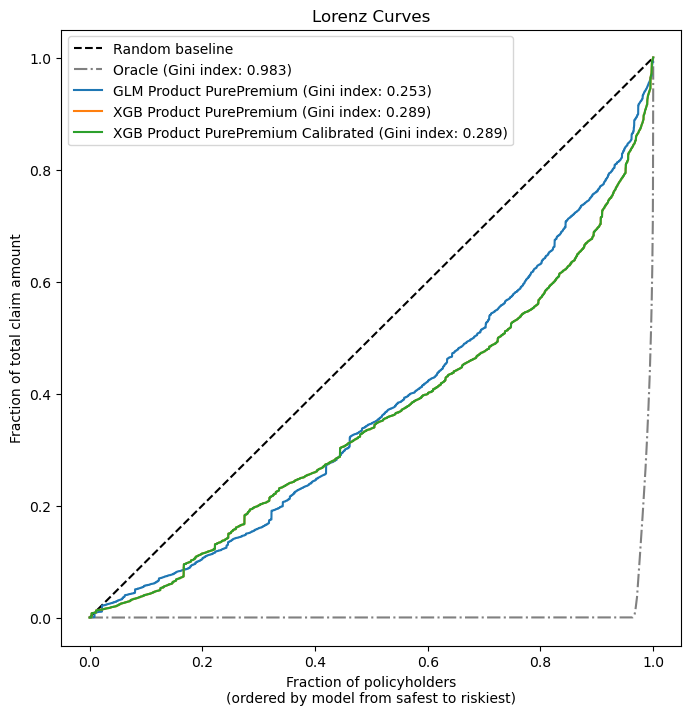

In [49]:
plot_risk_ranking(
    df_test["PurePremium"],
    df_test["Exposure"],
    {
        "GLM Product PurePremium": glm_poisson_freq.predict(
            X_test_glm
        ) * glm_gamma_sev.predict(X_test_glm),
        "XGB Product PurePremium": xgb_poisson_freq.predict(
            X_test_xgb_pure
        ) * xgb_gamma_sev.predict(X_test_xgb_pure),
        "XGB Product PurePremium Calibrated": xgb_poisson_freq.predict(
            X_test_xgb_pure
        ) * xgb_gamma_sev_calibrated.predict(X_test_xgb_pure),
    },
)

## Evaluation with SHAP

In [50]:
import shap

In [51]:
glm_tweedie_pure_exp = shap.LinearExplainer(
    glm_tweedie_pure, X_train_glm, output_names=feature_names_glm
)

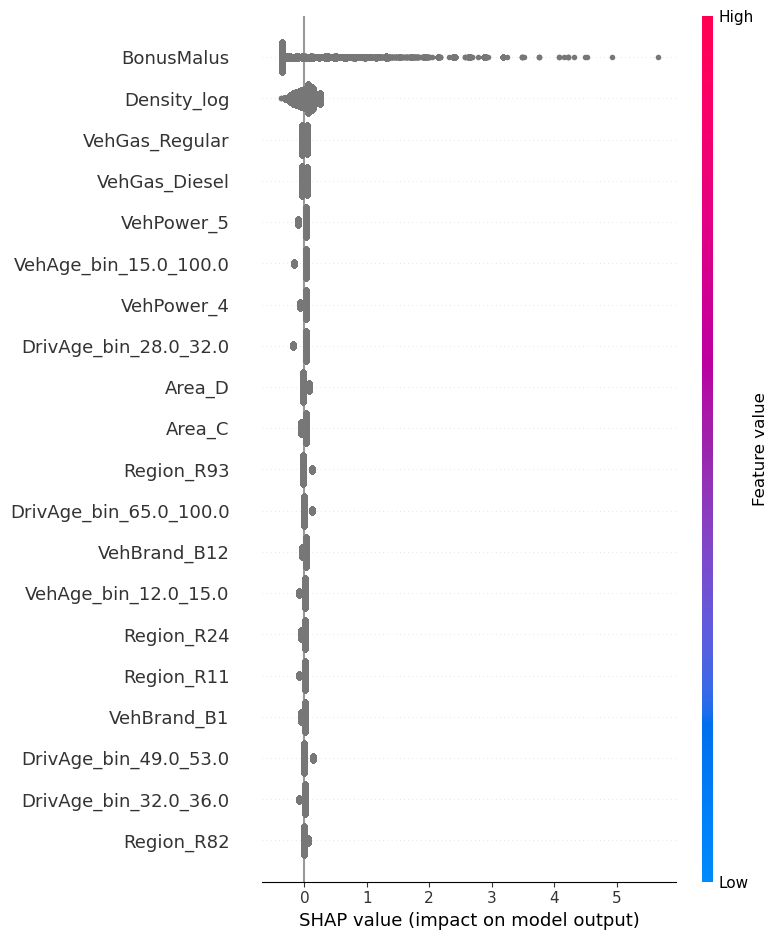

In [52]:
shap.summary_plot(
    glm_tweedie_pure_exp.shap_values(X_test_glm),
    X_test_glm,
    feature_names=feature_names_glm,
)

## Glossary

<a id="claim"></a>

**Claim**: A formal request to an insurance company asking for a payment based on the terms of the insurance policy.

<a id="frequency"></a>

**Frequency**: The number of claims per policyholder or per exposure unit over a given period of time.

<a id="purepremium"></a>

**Pure Premium**: The Premium the policyholder needs to pay to cover their risk. It is calculated as the expected value of the claim amount.

<a id="severity"></a>

**Severity**: The average cost of claims, calculated as the total cost of claims divided by the total number of claims.

<a id="totalclaimamount"></a>

**Total Claim Amount**: The total amount of money an insurance company pays out for all claims.